In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

In [3]:
def extract_feature_columns(df):
    '''Removes all default columns (contexts as well as fields like profileid which come in every event)'''
    ndf = df.copy()
    ndf.columns = [x.split('.')[1] for x in df.columns]
    default_cols = ['appid','spaceid','sessionid','playersessionid',
                    'profileid','totalplaytime','userid','clientip','countrycode',
                    'absoluteplaytime','relativeplaytime','release','app_name','spacename',
                    'country','business_region','geo_continent','subcontinent','region',
                    'serverdate','p_dateid','createddate','environment',
                    'installmentname','issampled','offline','eventid'
                   ]
    cols = [c for c in ndf.columns if "context" not in c and c not in default_cols]
    return ndf[cols]

In [30]:
# convert raw data to some interim steps
raw_path = '~/thedebugginator/data/raw'

bug_file = '{}/drone_melee_kills_1000.csv'.format(raw_path)
proper_file = '{}/drone_bullet_proper_10k.csv'.format(raw_path)

bug_df = pd.read_csv(bug_file)
proper_df = pd.read_csv(proper_file)

bug_df = extract_feature_columns(bug_df)
proper_df = extract_feature_columns(proper_df)

bug_df['label'] = 0
proper_df['label'] = 1

raw_df = pd.concat([proper_df,bug_df])

# now we are mostly done. need to identify numerical features, categorical features and remove old/useless features
bad_cols = ['enemyarchdescription','combatweaponusedname','combattypeofkillname',
            'playerheatlevel','powerlevel','enemylvl','copfelony','crimfelony','factionid'
           ]

raw_df.drop(bad_cols,inplace=True,axis=1)

numerical_features = ['ai_positionx','ai_positiony','ai_positionz',
                       'playerpositionx','playerpositiony','playerpositionz',
                       'killdist'
                      ]

categorical_features = [c for c in raw_df.columns if c not in numerical_features and c != 'label']

# turn categorical features into string data (easy for looping later)
raw_df.fillna(value={'combattakedown':0,'takedownstate':0},inplace=True)
raw_df[categorical_features] = raw_df[categorical_features].astype(str)

labels = raw_df.pop('label')

train_data, test_data, train_labels, test_labels = train_test_split(raw_df,labels,test_size=0.2,random_state=7)

In [35]:
# save the interim dataframes as examples
interim_path = '~/thedebugginator/data/interim'

train_data.to_csv(f'{interim_path}/full_training_data.csv')
test_data.to_csv(f'{interim_path}/full_testing_data.csv')
train_labels.to_csv(f'{interim_path}/full_training_labels.csv')
test_labels.to_csv(f'{interim_path}/full_testing_labels.csv')

# finish the preprocessing of the data
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data =  train_data[train_labels]
normal_test_data = test_data[test_labels]

bug_train_data = train_data[~train_labels]
bug_test_data = test_data[~test_labels]

normal_train_data.to_csv(f'{interim_path}/normal_training_data.csv')
normal_test_data.to_csv(f'{interim_path}/normal_testing_data.csv')
bug_train_data.to_csv(f'{interim_path}/bug_training_data.csv')
bug_test_data.to_csv(f'{interim_path}/bug_testing_data.csv')

In [44]:
numerical_inputs = []
categorical_inputs = []
normalized_features = []
encoded_features = []

for n in numerical_features:
    numerical_input = layers.Input(shape=(1,),dtype=tf.float32)
    normalizer = layers.Normalization()
    normalizer.adapt(normal_train_data[n])
    normalized = normalizer(numerical_input)
    numerical_inputs.append(numerical_input)
    normalized_features.append(normalized)

for c in categorical_features:
    categorical_input = layers.Input(shape=(1,),dtype=tf.string)
    onehot = layers.StringLookup(output_mode='one_hot')
    onehot.adapt(normal_train_data[c])
    encoded = onehot(categorical_input)
    categorical_inputs.append(categorical_input)
    encoded_features.append(encoded)

predict_list = []
for col in numerical_features+categorical_features:
    predict_list.append(normal_train_data[col])

output = layers.concatenate(normalized_features + encoded_features)
preprocesser = Model(inputs=numerical_inputs+categorical_inputs,outputs=[output])
predicted = preprocesser.predict(predict_list)

# save final preprocessing
processed_path = '~/thedebugginator/data/processed'
processed_df = pd.DataFrame(predicted)
processed_df.to_csv(f'{processed_path}/preprocessed_normal_training_data.csv',header=None,index=None)

In [45]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector,self).__init__()
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(32,activation='relu'),
            layers.Dense(16,activation='relu'),
            layers.Dense(4,activation='relu')
        ])
        
        self.decoder = tf.keras.Sequential([
            layers.Dense(16,activation='relu'),
            layers.Dense(32,activation='relu'),
            layers.Dense(157,activation='sigmoid')
        ])
        
    def call(self,x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [46]:
autoencoder = AnomalyDetector()
autoencoder.compile(optimizer='adam',loss='mae')

In [52]:
normal_trainer = predicted
predict_list = []
for col in numerical_features+categorical_features:
    predict_list.append(test_data[col])
full_test_data = preprocesser.predict(predict_list)

history = autoencoder.fit(normal_trainer, normal_trainer, 
          epochs=5, 
          batch_size=512,
          validation_data=(full_test_data, full_test_data),
          shuffle=True)

Epoch 1/5
16/16 [==============================] - 0s 6ms/step - loss: 0.0529 - val_loss: 0.0549
Epoch 2/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0528 - val_loss: 0.0547
Epoch 3/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0526 - val_loss: 0.0546
Epoch 4/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0525 - val_loss: 0.0546
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 0.0524 - val_loss: 0.0545


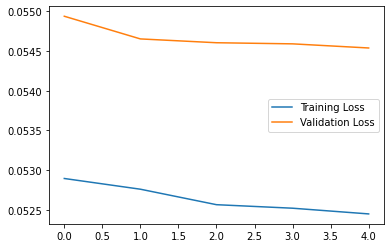

In [53]:
import matplotlib.pyplot as plt
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

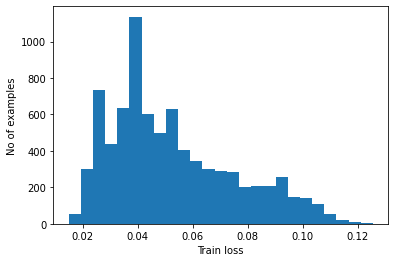

In [55]:
reconstructions = autoencoder.predict(normal_trainer)
train_loss = tf.keras.losses.mae(reconstructions, normal_trainer)

plt.hist(train_loss[None,:], bins=25)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

In [60]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.07510986


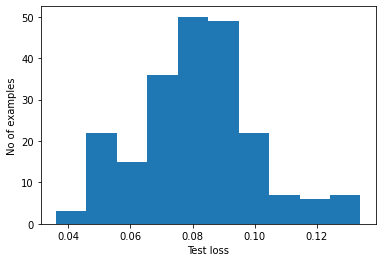

In [59]:
predict_list = []
for col in numerical_features+categorical_features:
    predict_list.append(bug_test_data[col])
anomalous_test_data = preprocesser.predict(predict_list)

reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=10)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

In [64]:
def predict(model, data, threshold):
    reconstructions = model(data)
    loss = tf.keras.losses.mae(reconstructions, data)
    return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
    accuracy = accuracy_score(labels, predictions)
    precision= precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    
    return accuracy,precision,recall

In [65]:
preds = predict(autoencoder, full_test_data, threshold)
accuracy,precision,recall = print_stats(preds, test_labels)
print('A: {}'.format(accuracy))
print('P: {}'.format(precision))
print('R: {}'.format(recall))
print('F1 : {}'.format(2*precision*recall/(precision+recall)))

A: 0.8163636363636364
P: 0.9560947429231658
R: 0.8345940494200706
F1 : 0.8912224017232095


In [74]:
# save the preprocessor and autoencoder
model_path = '/root/thedebugginator/models'
autoencoder.save(f'{model_path}/example_autoencoder')
preprocesser.save(f'{model_path}/example_preprocesser_onehot')

INFO:tensorflow:Assets written to: /root/thedebugginator/models/example_autoencoder/assets
INFO:tensorflow:Assets written to: /root/thedebugginator/models/example_preprocesser_onehot/assets
